In [1]:
# Visualize cached spectrograms (no rebuild) for all 27 activities of Subject S01
import yaml, os, re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.data.mmfi_wrap import build_mmfi_dataset, infer_batch_keys

In [4]:

# ---------- Config ----------
CFG_PATH = "configs/mmfi_e01.yaml"   # change if your config path differs
SAVE_FIG = True                      # set True to also save a montage image
SAVE_PATH = Path("runs/figures/s01111_spectrograms.png")
TITLE = "MM-Fi E01 • Subject S01 • Spectrograms (channel-mean)"

In [5]:
# ---------- Helpers ----------
def load_cached(path: str):
    if path.endswith(".npy"):
        return np.load(path, mmap_mode="r")
    elif path.endswith(".npz"):
        with np.load(path, allow_pickle=False) as f:
            return f["spec"]
    raise ValueError(f"Unknown cache file type: {path}")

def act_num(a: str) -> int:
    # Parse 'A01' or 'A1' -> 1
    m = re.search(r"(\d+)", a)
    return int(m.group(1)) if m else 999

In [6]:
# ---------- Load config and dataset metadata (fast, no spectrogram compute) ----------
cfg = yaml.safe_load(open(CFG_PATH, "r"))
cache_root = Path(cfg["cache"]["root"])
ext = ".npy" if cfg["cache"]["format"].lower() == "npy" else ".npz"

ds, _ = build_mmfi_dataset(cfg["dataset_root"], cfg)
if len(ds) == 0:
    raise RuntimeError("Dataset is empty. Check mmfi.manual_split subjects/actions in your YAML.")

In [7]:

data_key, label_key, subj_key = infer_batch_keys(ds[0])
print(f"Keys: data='{data_key}', label='{label_key}', subject='{subj_key}'")

Keys: data='input_wifi-csi', label='action', subject='subject'


In [8]:
# ---------- Collect S01 entries and map to cached files ----------
entries = []
for i in range(len(ds)):
    item = ds[i]
    subj = str(item.get(subj_key, item.get("subject", "")))
    if "S01" not in subj:
        continue
    act = str(item[label_key])   # e.g., 'A05'
    key = f"E01_{i:06d}"
    p = cache_root / f"{key}{ext}"
    if not p.exists():
        print(f"Warning: cache missing for index {i}: {p}")
        continue
    entries.append((i, act, str(p)))

In [9]:
# Sort by activity number A01..A27
entries.sort(key=lambda t: act_num(t[1]))
print(f"S01: found {len(entries)} cached sequences. Activities: {[e[1] for e in entries]}")

if len(entries) == 0:
    raise RuntimeError("No cached files found for S01. Check cache folder and config.")

S01: found 14 cached sequences. Activities: ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']


In [10]:
# ---------- Load specs and prepare channel-mean maps ----------
energy_maps, labels = [], []
for i, act, path in entries:
    spec = load_cached(path)      # [C, F, T']
    if spec.ndim != 3:
        raise ValueError(f"Unexpected spectrogram shape at {path}: {spec.shape}")
    energy = spec.mean(axis=0)    # [F, T'] channel-mean for visualization
    energy_maps.append(energy)
    labels.append(act)

# Consistent color scale across panels
vmin = min(em.min() for em in energy_maps)
vmax = max(em.max() for em in energy_maps)

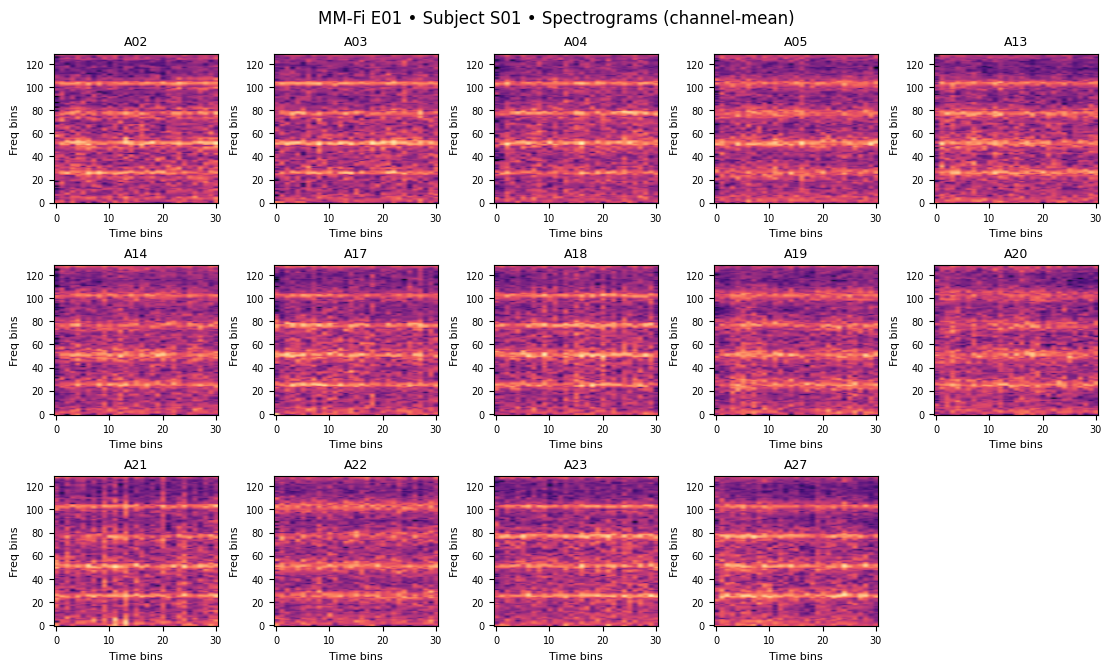

In [13]:


# ---------- Plot grid ----------
n = len(energy_maps)
ncols = 5
nrows = int(np.ceil(n / ncols))
fig_w, fig_h = 2.2 * ncols, 2.2 * nrows

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), constrained_layout=True)
axes = np.atleast_2d(axes)

for idx in range(nrows * ncols):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]
    if idx < n:
        em = energy_maps[idx]
        ax.imshow(em, origin="lower", aspect="auto", cmap="magma", vmin=vmin, vmax=vmax)
        ax.set_title(labels[idx], fontsize=9)
        ax.set_xlabel("Time bins", fontsize=8)
        ax.set_ylabel("Freq bins", fontsize=8)
        ax.tick_params(labelsize=7)
    else:
        ax.axis("off")

fig.suptitle(TITLE, fontsize=12)
plt.show()






In [14]:
if SAVE_FIG:
    SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(SAVE_PATH, dpi=200)
    print(f"Saved montage to: {SAVE_PATH}")

Saved montage to: runs\figures\s01111_spectrograms.png


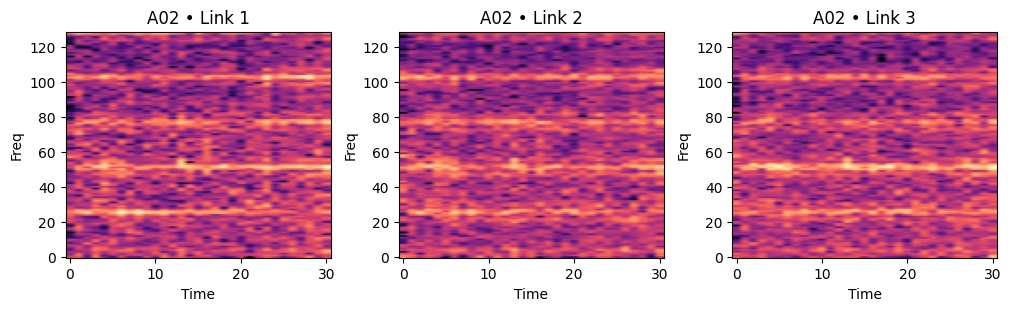

In [15]:
# ---------- Optional: per-link view for one activity (averaging PCs) ----------
# Uncomment and adjust sel_idx to inspect a specific activity panel in detail.
links = 3
k_pcs = int(cfg["spectrogram"].get("k_pcs", 4))
sel_idx = 0  # 0..len(entries)-1
spec = load_cached(entries[sel_idx][2])  # path
if spec.shape[0] == links * k_pcs:
    spec_l = spec.reshape(links, k_pcs, spec.shape[1], spec.shape[2]).mean(axis=1)  # [links, F, T']
    fig2, axs = plt.subplots(1, links, figsize=(10, 3), constrained_layout=True)
    for l in range(links):
        axs[l].imshow(spec_l[l], origin="lower", aspect="auto", cmap="magma", vmin=vmin, vmax=vmax)
        axs[l].set_title(f"{labels[sel_idx]} • Link {l+1}")
        axs[l].set_xlabel("Time"); axs[l].set_ylabel("Freq")
    plt.show()
else:
    print(f"Per-link view skipped: expected C={links*k_pcs}, got {spec.shape[0]}")